In [2]:
from docopt import docopt
import numpy as np
from pydap.client import open_url
from shapely.geometry import Point, Polygon
from pydap.cas.urs import setup_session 
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Opening a file path

url = 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/hyrax/GLDAS/GLDAS_CLSM10_M.2.1/2021/GLDAS_CLSM10_M.A202101.021.nc4'

username = 'aaroncp'      # please replace with your own username
password = 'H0ckey@6868'  # please replace with your own password
session = setup_session(username, password, check_url=url) # create Earthdata session
data = open_url(url, session=session) 

minLat = 28
maxLat = 52
minLon = -124
maxLon = -100


ut_file = './boundary_UT.csv'

utBound =np.genfromtxt(ut_file, delimiter=',', skip_header=1)

tuple(utBound[0,:])

utBoundList = []
    
for i in range(len(utBound)):
    utBoundList.append(tuple(utBound[i,:]))

utPoly = Polygon(utBoundList)

# Download a subset of the data

lat = data['lat'][:].data
lon = data['lon'][:].data
snowFall = data['Snowf_tavg']
snowFall.attributes 


latGrid, lonGrid = np.meshgrid(lat,lon)

where_minLat = np.argmin(np.abs(lat-minLat))
where_maxLat = np.argmin(np.abs(lat-maxLat))
where_minLon = np.argmin(np.abs(lon-minLon))
where_maxLon = np.argmin(np.abs(lon-maxLon))

grid = snowFall[:,where_minLat:where_maxLat,where_minLon:where_maxLon]

snow_bound = grid['Snowf_tavg'][:].data
snow_bound[snow_bound == -9999.0] = np.nan

lat1 = grid['lat'][:].data
lon1 = grid['lon'][:].data
time = grid['time'][:].data

lat1_grid, lon1_grid = np.meshgrid(lat1,lon1)

latGrid_bound = latGrid[where_minLat:where_maxLat,where_minLon:where_maxLon]
lonGrid_bound = lonGrid[where_minLat:where_maxLat,where_minLon:where_maxLon]

lon1_bo = lon[where_minLon:where_maxLon]
lat1_bo = lat[where_minLat:where_maxLat]

# Generating masks for the bounded files

utMask = np.zeros(snow_bound.shape[1:])

for lo_i in range(len(lon1_bo)):
    for la_i in range(len(lat1_bo)):
        lo = lon1_bo[lo_i]
        la = lat1_bo[la_i]  
        currentPoint = Point(la,lo)        
        check = currentPoint.within(utPoly)
        utMask[la_i,lo_i] = int(check)

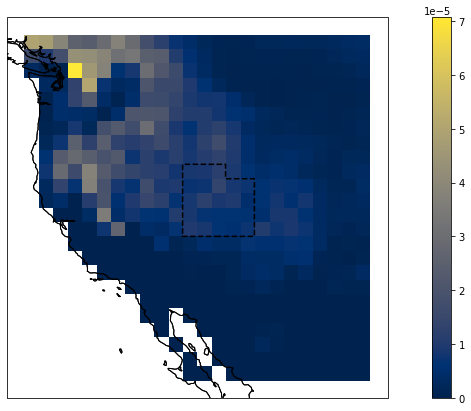

In [3]:
# Generate polot of the bounded box and include the masked regions
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.plot(utBound[:,1],utBound[:,0],'k--')
plt.pcolormesh(lon1_bo,lat1_bo, snow_bound[0],shading='auto',cmap='cividis',transform=ccrs.PlateCarree()) 
cbar = plt.colorbar()
ax.coastlines()
plt.show()